In [10]:
import torch
import itertools
import torch.nn as nn
from timm.models.vision_transformer import trunc_normal_
from timm.models.layers import SqueezeExcite
# from ..model import MODEL
from model.lib_mamba.vmambanew import SS2D
import torch.nn.functional as F
from functools import partial
import pywt
import pywt.data
from timm.layers import DropPath

def create_wavelet_filter(wave, in_size, out_size, type=torch.float):
    w = pywt.Wavelet(wave)
    dec_hi = torch.tensor(w.dec_hi[::-1], dtype=type)
    dec_lo = torch.tensor(w.dec_lo[::-1], dtype=type)
    dec_filters = torch.stack([dec_lo.unsqueeze(0) * dec_lo.unsqueeze(1),
                               dec_lo.unsqueeze(0) * dec_hi.unsqueeze(1),
                               dec_hi.unsqueeze(0) * dec_lo.unsqueeze(1),
                               dec_hi.unsqueeze(0) * dec_hi.unsqueeze(1)], dim=0)

    dec_filters = dec_filters[:, None].repeat(in_size, 1, 1, 1)

    rec_hi = torch.tensor(w.rec_hi[::-1], dtype=type).flip(dims=[0])
    rec_lo = torch.tensor(w.rec_lo[::-1], dtype=type).flip(dims=[0])
    rec_filters = torch.stack([rec_lo.unsqueeze(0) * rec_lo.unsqueeze(1),
                               rec_lo.unsqueeze(0) * rec_hi.unsqueeze(1),
                               rec_hi.unsqueeze(0) * rec_lo.unsqueeze(1),
                               rec_hi.unsqueeze(0) * rec_hi.unsqueeze(1)], dim=0)

    rec_filters = rec_filters[:, None].repeat(out_size, 1, 1, 1)

    return dec_filters, rec_filters

def wavelet_transform(x, filters):
    b, c, h, w = x.shape
    pad = (filters.shape[2] // 2 - 1, filters.shape[3] // 2 - 1)
    x = F.conv2d(x, filters, stride=2, groups=c, padding=pad)
    x = x.reshape(b, c, 4, h // 2, w // 2)
    return x


def inverse_wavelet_transform(x, filters):
    b, c, _, h_half, w_half = x.shape
    pad = (filters.shape[2] // 2 - 1, filters.shape[3] // 2 - 1)
    x = x.reshape(b, c * 4, h_half, w_half)
    x = F.conv_transpose2d(x, filters, stride=2, groups=c, padding=pad)
    return x

# class MBWTConv2d(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, bias=True, wt_levels=1, wt_type='db1',ssm_ratio=1,forward_type="v05",):
#         super(MBWTConv2d, self).__init__()

#         assert in_channels == out_channels

#         self.in_channels = in_channels
#         self.wt_levels = wt_levels
#         self.stride = stride
#         self.dilation = 1

#         self.wt_filter, self.iwt_filter = create_wavelet_filter(wt_type, in_channels, in_channels, torch.float)
#         self.wt_filter = nn.Parameter(self.wt_filter, requires_grad=False)
#         self.iwt_filter = nn.Parameter(self.iwt_filter, requires_grad=False)

#         self.wt_function = partial(wavelet_transform, filters=self.wt_filter)
#         self.iwt_function = partial(inverse_wavelet_transform, filters=self.iwt_filter)

#         self.global_atten =SS2D(d_model=in_channels, d_state=1,
#              ssm_ratio=ssm_ratio, initialize="v2", forward_type=forward_type, channel_first=True, k_group=2)
#         self.base_scale = _ScaleModule([1, in_channels, 1, 1])

#         self.wavelet_convs = nn.ModuleList(
#             [nn.Conv2d(in_channels * 4, in_channels * 4, kernel_size, padding='same', stride=1, dilation=1,
#                        groups=in_channels * 4, bias=False) for _ in range(self.wt_levels)]
#         )

#         self.wavelet_scale = nn.ModuleList(
#             [_ScaleModule([1, in_channels * 4, 1, 1], init_scale=0.1) for _ in range(self.wt_levels)]
#         )

#         if self.stride > 1:
#             self.stride_filter = nn.Parameter(torch.ones(in_channels, 1, 1, 1), requires_grad=False)
#             self.do_stride = lambda x_in: F.conv2d(x_in, self.stride_filter, bias=None, stride=self.stride,
#                                                    groups=in_channels)
#         else:
#             self.do_stride = None

#     def forward(self, x):

#         x_ll_in_levels = []
#         x_h_in_levels = []
#         shapes_in_levels = []
        
#         curr_x_ll = x

#         for i in range(self.wt_levels):
#             print(f"Wavelet level {i + 1} of {self.wt_levels}")
#             curr_shape = curr_x_ll.shape
#             shapes_in_levels.append(curr_shape)
#             if (curr_shape[2] % 2 > 0) or (curr_shape[3] % 2 > 0):
#                 curr_pads = (0, curr_shape[3] % 2, 0, curr_shape[2] % 2)
#                 curr_x_ll = F.pad(curr_x_ll, curr_pads)

#             curr_x = self.wt_function(curr_x_ll)
#             curr_x_ll = curr_x[:, :, 0, :, :]

#             shape_x = curr_x.shape
#             curr_x_tag = curr_x.reshape(shape_x[0], shape_x[1] * 4, shape_x[3], shape_x[4])
#             curr_x_tag = self.wavelet_scale[i](self.wavelet_convs[i](curr_x_tag))
#             curr_x_tag = curr_x_tag.reshape(shape_x)

#             x_ll_in_levels.append(curr_x_tag[:, :, 0, :, :])
#             x_h_in_levels.append(curr_x_tag[:, :, 1:4, :, :])

#         next_x_ll = 0

#         for i in range(self.wt_levels - 1, -1, -1):
#             curr_x_ll = x_ll_in_levels.pop()
#             curr_x_h = x_h_in_levels.pop()
#             curr_shape = shapes_in_levels.pop()

#             curr_x_ll = curr_x_ll + next_x_ll

#             curr_x = torch.cat([curr_x_ll.unsqueeze(2), curr_x_h], dim=2)
#             next_x_ll = self.iwt_function(curr_x)

#             next_x_ll = next_x_ll[:, :, :curr_shape[2], :curr_shape[3]]

#         x_tag = next_x_ll
#         assert len(x_ll_in_levels) == 0

#         x = self.base_scale(self.global_atten(x))
#         x = x + x_tag

#         if self.do_stride is not None:
#             x = self.do_stride(x)

#         return x

# class _ScaleModule(nn.Module):
#     def __init__(self, dims, init_scale=1.0, init_bias=0):
#         super(_ScaleModule, self).__init__()
#         self.dims = dims
#         self.weight = nn.Parameter(torch.ones(*dims) * init_scale)
#         self.bias = None

#     def forward(self, x):
#         return torch.mul(self.weight, x)
    

# model = MBWTConv2d(64,64)
# x = torch.randn(1, 64, 32, 32)
# output = model(x)
# print(output.shape)


In [11]:
print(model)

NameError: name 'model' is not defined

In [12]:
def create_wavelet_filter(wave, in_size, out_size, type=torch.float):
    w = pywt.Wavelet(wave)
    dec_hi = torch.tensor(w.dec_hi[::-1], dtype=type)
    dec_lo = torch.tensor(w.dec_lo[::-1], dtype=type)
    dec_filters = torch.stack([dec_lo.unsqueeze(0) * dec_lo.unsqueeze(1),
                               dec_lo.unsqueeze(0) * dec_hi.unsqueeze(1),
                               dec_hi.unsqueeze(0) * dec_lo.unsqueeze(1),
                               dec_hi.unsqueeze(0) * dec_hi.unsqueeze(1)], dim=0)

    dec_filters = dec_filters[:, None].repeat(in_size, 1, 1, 1)

    rec_hi = torch.tensor(w.rec_hi[::-1], dtype=type).flip(dims=[0])
    rec_lo = torch.tensor(w.rec_lo[::-1], dtype=type).flip(dims=[0])
    rec_filters = torch.stack([rec_lo.unsqueeze(0) * rec_lo.unsqueeze(1),
                               rec_lo.unsqueeze(0) * rec_hi.unsqueeze(1),
                               rec_hi.unsqueeze(0) * rec_lo.unsqueeze(1),
                               rec_hi.unsqueeze(0) * rec_hi.unsqueeze(1)], dim=0)

    rec_filters = rec_filters[:, None].repeat(out_size, 1, 1, 1)

    return dec_filters, rec_filters

wt_filters, iwt_filters = create_wavelet_filter('db1', 3, 3, torch.float)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 4, 256, 256])
torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])
[[[38 49 47]
  [43 53 52]
  [40 51 47]
  ...
  [53 66 58]
  [52 64 54]
  [51 63 53]]

 [[41 52 48]
  [42 53 50]
  [40 52 48]
  ...
  [51 63 58]
  [53 65 54]
  [54 66 55]]

 [[42 56 49]
  [43 55 50]
  [38 51 47]
  ...
  [52 62 60]
  [55 66 60]
  [55 67 57]]

 ...

 [[44 57 45]
  [45 56 45]
  [47 57 47]
  ...
  [46 54 49]
  [45 54 49]
  [46 55 50]]

 [[46 59 48]
  [44 57 44]
  [45 58 46]
  ...
  [46 56 48]
  [44 54 49]
  [44 53 52]]

 [[44 59 46]
  [41 56 43]
  [41 56 43]
  ...
  [45 54 49]
  [44 54 51]
  [47 55 56]]]
[[[ 81 103  98]
  [ 78 102  94]
  [ 78 101  94]
  ...
  [108 129 123]
  [106 130 121]
  [104 128 107]]

 [[ 83 109  98]
  [ 80 104  97]
  [ 80 105  95]
  ...
  [103 124 120]
  [104 126 121]
  [109 131 119]]

 [[ 82 105  97]
  [ 85 104 101]
  [ 78  99  94]
  ...
  [107 125 125]
  [102 123 121]
  [103 123 121]]

 ...

 [[ 82 115  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[254 255 255]
  [  0   1   0]
  [255   0 255]
  ...
  [  0   0   0]
  [  0 255   0]
  [  1   1   1]]

 [[  0   0   0]
  [255 255   0]
  [  1   1   2]
  ...
  [  0 255   0]
  [  0   1   0]
  [  0   0   0]]

 [[255   0   0]
  [  0   0   0]
  [  0   1   0]
  ...
  [  0   0   0]
  [  2   1   1]
  [  0 255 254]]

 ...

 [[255   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [254   0   0]
  [255   0 255]]

 [[  0   0   0]
  [254   0 255]
  [  0   0   0]
  ...
  [  0   0   1]
  [  0   0   0]
  [  0   1   1]]

 [[  0   0   0]
  [  0   1   1]
  [255 255 254]
  ...
  [  0   0   0]
  [  0   0   1]
  [  1   1   1]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


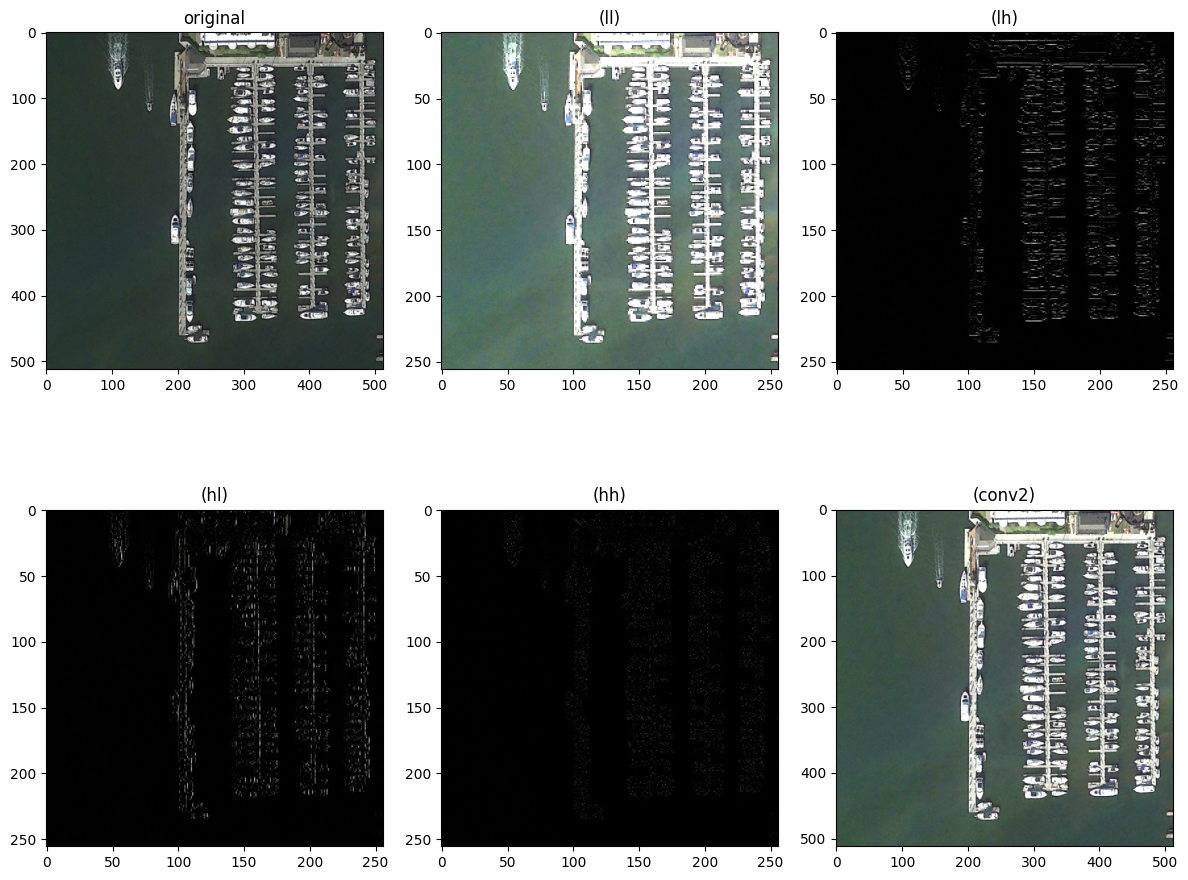

重构MSE误差: 0.025970


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import cv2
# 加载图像并转换为张量
img = Image.open("/Data_8TB/lht/data/DIOR/JPEGImages-trainval/00007.jpg") # 转为灰度图

transform = transforms.Compose([
        transforms.Resize((512,512)),  # 确保尺寸为2的倍数
        transforms.ToTensor()
])

wt_filter = nn.Parameter(wt_filters, requires_grad=False)
iwt_filter = nn.Parameter(iwt_filters, requires_grad=False)


wt_function = partial(wavelet_transform, filters=wt_filter)
iwt_function = partial(inverse_wavelet_transform, filters=iwt_filter)

x = transform(img).unsqueeze(0)

x = x[:,:3,:,:]

print(wt_function(x).shape)
ll = wt_function(x)[:,:,0,:,:]
lh = wt_function(x)[:,:,1,:,:]
hl = wt_function(x)[:,:,2,:,:] 
hh = wt_function(x)[:,:,3,:,:]

print(ll.shape, lh.shape, hl.shape, hh.shape,)



# 可视化结果
plt.figure(figsize=(12, 10))
plt.subplot(2, 3, 1)
plt.imshow(x.permute(0,2,3,1).squeeze().numpy())

plt.title("original")
origin_image = (x.permute(0,2,3,1).squeeze().numpy() * 255).astype(np.uint8)
print(origin_image)
img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('DWImage/origin.jpg', img)

plt.subplot(2, 3, 2)
plt.imshow(ll.permute(0,2,3,1).squeeze().detach().numpy(), cmap='gray')
plt.title("(ll)")
origin_image = (ll.permute(0,2,3,1).squeeze().detach().numpy() * 255).astype(np.uint8)
print(origin_image)
img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('DWImage/ll.jpg', img)
    
plt.subplot(2, 3, 3)
plt.imshow(lh.permute(0,2,3,1).squeeze().detach().numpy(), cmap='gray')
plt.title("(lh)")
origin_image = (lh.permute(0,2,3,1).squeeze().detach().numpy() * 255).astype(np.uint8)
print(origin_image)
img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('DWImage/lh.jpg', img)
    
plt.subplot(2, 3, 4)
plt.imshow(hl.permute(0,2,3,1).squeeze().detach().numpy(), cmap='gray')
plt.title("(hl)")
origin_image = (hl.permute(0,2,3,1).squeeze().detach().numpy() * 255).astype(np.uint8)
print(origin_image)
img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('DWImage/hl.jpg', img)

plt.subplot(2, 3, 5)
plt.imshow(hh.permute(0,2,3,1).squeeze().detach().numpy(), cmap='gray')
plt.title("(hh)")
origin_image = (hh.permute(0,2,3,1).squeeze().detach().numpy() * 255).astype(np.uint8)
print(origin_image)
img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('DWImage/hh.jpg', img)
    
plt.subplot(2, 3, 6)
plt.imshow(((nn.functional.hardsigmoid(hl*lh)*ll)+2*ll).permute(0,2,3,1).squeeze().detach().numpy(), cmap='gray')
plt.title("(q+k)*v")


origin_image = (((hl*lh).permute(0,2,3,1)).squeeze().detach().numpy() * 255).astype(np.uint8)
print(origin_image)
img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('DWImage/hl*lh.jpg', img)

# origin_image = (((nn.functional.hardsigmoid(hl*lh)*ll)+ll).permute(0,2,3,1).squeeze().detach().numpy()).astype(np.uint8)
# print(origin_image)
# img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
# cv2.imwrite('DWImage/WTLL.jpg', img)


# plt.subplot(2, 3, 6)
# plt.imshow(((nn.functional.hardsigmoid(hl*lh)*ll)+ll).permute(0,2,3,1).squeeze().detach().numpy(), cmap='gray')
# plt.title("((q*k)*v)+v")



plt.savefig('DWImage/original_1.jpg')

self_attn = (nn.functional.hardsigmoid((lh*hl))*ll)+ll


m = torch.cat([self_attn.unsqueeze(2), lh.unsqueeze(2), hl.unsqueeze(2), hh.unsqueeze(2)], dim=2)

m = iwt_function(m)


plt.subplot(2, 3, 6)
plt.imshow(m.permute(0,2,3,1).squeeze().detach().numpy(), cmap='gray')
plt.title("(conv2)")


# origin_image = (m.permute(0,2,3,1).squeeze().detach().numpy() * 255).astype(np.uint8)
# print(origin_image)
# img = cv2.cvtColor(origin_image, cv2.COLOR_RGB2BGR)
# cv2.imwrite('DWImage/DWT.jpg', img)


plt.tight_layout()
plt.show()

mse = F.mse_loss(x, m).item()
print(f"重构MSE误差: {mse:.6f}")



In [ ]:
class WTAttn(nn.Module):
    def __init__(self, dim, wt_type='db1'):
        super(WTAttn, self).__init__()
        wt_filter, iwt_filter = create_wavelet_filter('db1', 3, 3, torch.float)
        self.wt_function = partial(wavelet_transform, filters=wt_filter)
        self.iwt_function = partial(inverse_wavelet_transform, filters=iwt_filter)
        self.lh_conv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim, bias=False)
        self.hl_conv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim, bias=False)
        self.ll_conv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim, bias=False)
        self.act = nn.Hardsigmoid()
    
    def forward(self, x):
        x_wt = self.wt_function(x)
        ll, lh, hl, hh = x_wt[:, :, 0, :, :], x_wt[:, :, 1, :, :], x_wt[:, :, 2, :, :], x_wt[:, :, 3, :, :]
        
        # Apply convolutions
        lh_conv = self.lh_conv(lh)
        hl_conv = self.hl_conv(hl)
        ll_conv = self.ll_conv(ll)
        
        # Combine results
        attn = (self.act(lh_conv * hl_conv) * ll) + ll
        wt_map = torch.cat([attn.unsqueeze(2), lh.unsqueeze(2), hl.unsqueeze(2), hh.unsqueeze(2)], dim=2)
        output = self.iwt_function(wt_map)

        return output



In [ ]:
from model.mobilemamba.mobilemamba import *
from model.mobilemamba.mobilemamba import MobileMamba_T2, MobileMamba_T4, MobileMamba_S6, MobileMamba_B1, MobileMamba_B2, MobileMamba_B4

from fvcore.nn import FlopCountAnalysis, flop_count_table, parameter_count
from util.util import FLOPs, Throughput, get_val_dataloader
import time
import argparse

def replace_batchnorm(net):
    for child_name, child in net.named_children():
        if hasattr(child, 'fuse'):
            fused = child.fuse()
            setattr(net, child_name, fused)
            replace_batchnorm(fused)
        elif isinstance(child, torch.nn.BatchNorm2d):
            setattr(net, child_name, torch.nn.Identity())
        else:
            replace_batchnorm(child)

def get_timepc():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    return time.perf_counter()


model_dict = {
        "MobileMamba_T2": MobileMamba_T2,
        "MobileMamba_T4": MobileMamba_T4,
        "MobileMamba_S6": MobileMamba_S6,
        "MobileMamba_B1": MobileMamba_B1,
        "MobileMamba_B2": MobileMamba_B2,
        "MobileMamba_B4": MobileMamba_B4,
    }

parser = argparse.ArgumentParser()
parser.add_argument('-b', '--batchsize', type=int, default=256)
parser.add_argument('-i', '--imagesize', type=int, default=224)
parser.add_argument('-m', '--modelname', default="MobileMamba_S6")
cfg = parser.parse_args()
bs = cfg.batchsize
img_size = cfg.imagesize
model_name = cfg.modelname
print('batch_size is:', bs, 'img_size is:', img_size, 'model_name is:', model_dict[model_name])
gpu_id = 0
speed = True
latency = True
with torch.no_grad():
    x = torch.randn(bs, 3, img_size, img_size)
    net = model_dict[model_name]()
    replace_batchnorm(net)
    net.eval()
    pre_cnt, cnt = 2, 5
    if gpu_id > -1:
        torch.cuda.set_device(gpu_id)
        x = x.cuda()
        net.cuda()
        pre_cnt, cnt = 50, 20
    FLOPs.fvcore_flop_count(net, torch.randn(1, 3, img_size, img_size).cuda(), show_arch=False)

     #GPU
    for _ in range(pre_cnt):
        net(x)
    t_s = get_timepc()
    for _ in range(cnt):
        net(x)
    t_e = get_timepc()
    speed = f'{bs * cnt / (t_e - t_s):>7.3f}'
    print(f'[Batchsize: {bs}]\t [GPU-Speed: {speed}]\t')


usage: ipykernel_launcher.py [-h] [-b BATCHSIZE] [-i IMAGESIZE] [-m MODELNAME]
ipykernel_launcher.py: error: unrecognized arguments: --f=/run/user/1000/jupyter/runtime/kernel-v369094e0dbd313327a433c7cf35445840f9b5589d.json


SystemExit: 2

/Data_8TB/requirements/Miniconda3/envs/mobilemamba/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


/Data_8TB/requirements/Miniconda3/envs/mobilemamba/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Data_8TB/requirements/Miniconda3/envs/mobilemamba/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Data_8TB/requirements/Miniconda3/envs/mobilemamba/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Data_8TB/requirements/Miniconda3/envs/mobilemamba/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Data_8TB/requirements/Miniconda3/envs/mobilemam

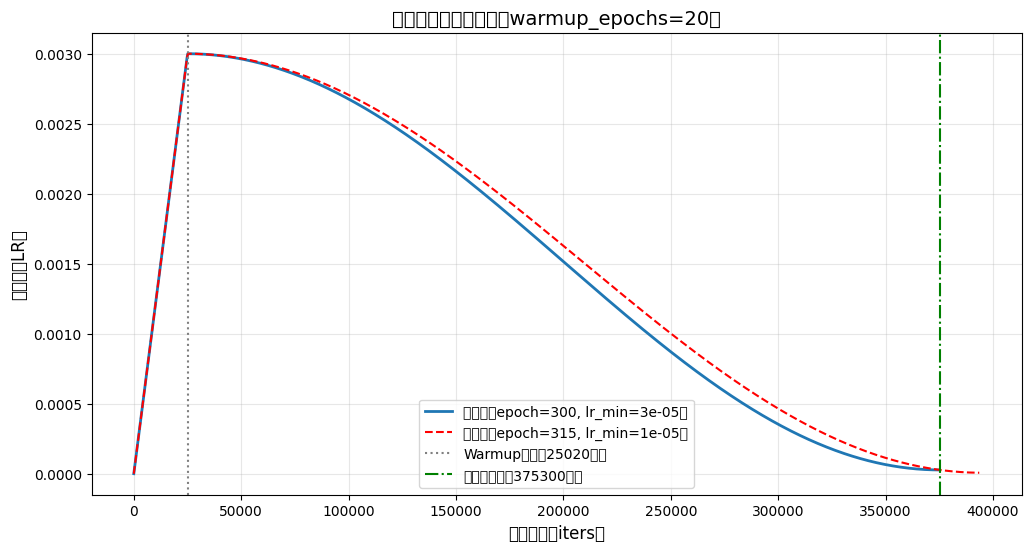

原训练轮数：300 → 新训练轮数：315
原总步数：375300 → 新总步数：394562
在原训练结束时（375300步）：
  原曲线LR：0.00003000
  新曲线LR：0.00003000


In [ ]:
import math
import matplotlib.pyplot as plt

# 固定参数
lr0 = 0.003
lr_min_old = 0.003 / 100  # 原最小学习率：0.00003
lr_min_new = 0.00001       # 新最小学习率
T_old = 375300             # 原总步数
epoch_old = 300            # 原训练轮数
warmup_epochs = 20         # 用户提供的warmup轮数
S = T_old // epoch_old     # 每epoch步数：1251

# 计算关键参数
W = warmup_epochs * S                  # Warmup总步数：25020
D_old = T_old - W                      # 原衰减阶段步数：350280
D_new = int(round((math.pi * D_old) / math.acos(-0.986622)))  # 新衰减阶段步数：370876
T_new = D_new + W                      # 新总步数：395896
epoch_new = T_new // S                 # 新训练轮数：317

# 定义学习率计算函数
def get_lr(t, lr_min, decay_steps, warmup_steps, initial_lr, warmup_lr=0.000003):
    if t < warmup_steps:
        # Warmup阶段：线性上升
        return warmup_lr + (initial_lr - warmup_lr) * (t / warmup_steps)
    else:
        # Cosine衰减阶段
        t_decay = t - warmup_steps
        return lr_min + 0.5 * (initial_lr - lr_min) * (1 + math.cos(math.pi * t_decay / decay_steps))

# 生成采样点（原总步数内的1000个点，验证重合性）
sample_points = 1000
t_list = [i * (T_old // sample_points) for i in range(sample_points)]
t_list_new = [i * (T_new // sample_points) for i in range(sample_points)]

# 计算新旧学习率曲线
lr_old_list = [get_lr(t, lr_min_old, D_old, W, lr0) for t in t_list]
lr_new_list = [get_lr(t, lr_min_new, D_new, W, lr0) for t in t_list_new]

# 绘制曲线
plt.figure(figsize=(12, 6))
plt.plot(t_list, lr_old_list, label=f'原曲线（epoch={epoch_old}, lr_min={lr_min_old}）', linewidth=2)
plt.plot(t_list_new, lr_new_list, label=f'新曲线（epoch={epoch_new}, lr_min={lr_min_new}）', 
         linewidth=1.5, linestyle='--', color='red')

# 标注关键节点
plt.axvline(x=W, color='gray', linestyle=':', label=f'Warmup结束（{W}步）')
plt.axvline(x=T_old, color='green', linestyle='-.', label=f'原训练结束（{T_old}步）')

plt.xlabel('训练步数（iters）', fontsize=12)
plt.ylabel('学习率（LR）', fontsize=12)
plt.title('学习率曲线重合验证（warmup_epochs=20）', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# 输出关键参数
print(f"原训练轮数：{epoch_old} → 新训练轮数：{epoch_new}")
print(f"原总步数：{T_old} → 新总步数：{T_new}")
print(f"在原训练结束时（{T_old}步）：")
print(f"  原曲线LR：{get_lr(T_old, lr_min_old, D_old, W, lr0):.8f}")
print(f"  新曲线LR：{get_lr(T_old, lr_min_new, D_new, W, lr0):.8f}")  # 应相等


In [ ]:
import torch

In [ ]:
q = torch.randn([1,4,16,56,56])
k = torch.randn([1,4,16,56,56])
v = torch.randn([1,4,16,56,56])

attn_weight = torch.matmul(q.view(1,56,56,16,4),k.view(1,56,56,4,16))  # 结果是[1,4,4,56,56]
torch.matmul(v.view(1,56,56,4,16),q.view(1,56,56,4,16)).shape  # 结果是[1,16,16,56,56]


torch.Size([1, 56, 56, 16, 16])

In [ ]:
x*y

RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 2

In [ ]:
x = torch.randn([1,56,56,4,16])
y = torch.randn([1,56,56,16,4])

RuntimeError: The size of tensor a (16) must match the size of tensor b (4) at non-singleton dimension 4

In [ ]:
import torch
import torch.nn as nn
import time

# --- 配置 ---
# 选择 GPU 设备
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 测试参数
input_sizes = [
    (96, 56, 56),   # (C, H, W)
    (192, 28, 28),
    (384, 14, 14),
    (768, 7, 7)
]
num_layers = 10  # 堆叠层数
kernel_size = 3
batch_size_throughput = 32  # 用于测量吞吐量的批量大小
num_warmup_iters = 10       # 预热迭代次数
num_benchmark_iters = 100   # 基准测试迭代次数

# --- 定义模型 ---
class StackedConvModel(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, num_layers=10):
        super(StackedConvModel, self).__init__()
        layers = []
        current_channels = in_channels
        # 堆叠 num_layers 层 Conv3x3
        for _ in range(num_layers):
            layers.append(
                nn.Conv2d(current_channels, current_channels, kernel_size=kernel_size, padding=1, bias=False)
            )
            # 如果输入输出通道不同，可以在这里添加调整层（但本例中保持通道数一致）
            # current_channels = out_channels 
        self.features = nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)

# --- 计算理论 FLOPs (使用 torch.profiler) ---
def calculate_flops(model, input_tensor):
    # 使用 torch.profiler.profile 来计算 MACs (Multiply-Accumulates)
    # 通常 1 FLOP ≈ 2 MACs (一次乘法和一次加法)，但论文和许多库将 1 MAC 视为 1 FLOP
    # 我们遵循论文的惯例，将 MACs 视为 FLOPs
    with torch.profiler.profile(with_flops=True) as prof:
        with torch.no_grad():
            model(input_tensor)
    
    # 提取总的 FLOPs (在这里实际上是 MACs)
    # 注意：prof.key_averages() 包含很多项，我们需要累加相关的
    # 一个更简单的方法是使用 fvcore 或 thop 库，但这里我们手动计算理论值作为验证
    # 理论 FLOPs 计算: 对于每个 Conv 层: H * W * K * K * C_in * C_out
    # 由于我们这里 C_in == C_out == C, 且 K=3, padding=1 (输出尺寸不变)
    # 每层 FLOPs = H * W * 9 * C * C
    # 总 FLOPs = num_layers * H * W * 9 * C^2
    # 但我们使用 profiler 来获取更准确的（包括所有操作的）FLOPs
    
    # 从 profiler 结果中获取总 FLOPs (MACs)
    total_flops_from_profiler = sum([evt.flops for evt in prof.key_averages()]) # 注意：这包含了所有事件的 FLOPs
    # 通常我们只关心模型 forward pass 的 FLOPs，所以需要过滤
    # 但为了简化，我们假设主要的 FLOPs 来自卷积层
    # 更精确的方法是使用特定的库如 fvcore
    
    # 手动计算理论 FLOPs (按论文定义，一次乘加算一次 FLOP)
    # 对于 3x3 Conv, padding=1, output_size = input_size
    theoretical_flops_per_layer = input_tensor.shape[2] * input_tensor.shape[3] * (kernel_size**2) * input_tensor.shape[1] * input_tensor.shape[1]
    theoretical_total_flops = num_layers * theoretical_flops_per_layer
    
    return theoretical_total_flops # 返回手动计算的理论值，与论文 Table 1 一致


# --- 测量吞吐量 (Throughput) ---
def benchmark_throughput(model, input_tensor, num_warmup_iters, num_benchmark_iters):
    model.eval()
    
    # Warmup
    with torch.no_grad():
        for _ in range(num_warmup_iters):
            _ = model(input_tensor)
    
    # Synchronize GPU before starting the timer
    torch.cuda.synchronize()
    start_time = time.time()
    
    # Benchmark
    with torch.no_grad():
        for _ in range(num_benchmark_iters):
            _ = model(input_tensor)
    
    # Synchronize GPU after finishing the timer
    torch.cuda.synchronize()
    end_time = time.time()
    
    total_time = end_time - start_time
    total_samples = num_benchmark_iters * input_tensor.shape[0]
    throughput_fps = total_samples / total_time
    
    return throughput_fps

# --- 主测试循环 ---
print("-" * 80)
print(f"{'Feature map size':<20} {'FLOPs (M)':<15} {'Throughput (fps)':<20} {'FLOPS (G/s)':<15}")
print("-" * 80)

total_flops_sum = 0
total_throughput_sum = 0
count = 0

for c, h, w in input_sizes:
    print(f"Testing input size: C={c}, H={h}, W={w}")
    
    # 1. 创建模型和输入张量
    model = StackedConvModel(in_channels=c, out_channels=c, kernel_size=kernel_size, num_layers=num_layers)
    model = model.to(device)
    
    # 创建批量输入
    input_tensor = torch.randn(batch_size_throughput, c, h, w, device=device)
    
    # 2. 计算 FLOPs (理论值)
    # 注意：这里的计算假设输入输出通道数相同，且 padding=1 保持尺寸不变
    # 每层 FLOPs = H * W * K^2 * C^2
    flops_per_layer = h * w * (kernel_size ** 2) * (c ** 2)
    total_flops = num_layers * flops_per_layer
    total_flops_millions = total_flops / 1e6 # 转换为 Millions of FLOPs (MFLOPs)
    
    # (可选) 使用 profiler 验证 (注释掉以简化)
    # profiled_flops = calculate_flops(model, input_tensor[:1, ...]) / 1e6 # Profile 单个样本
    
    # 3. 测量吞吐量
    throughput_fps = benchmark_throughput(model, input_tensor, num_warmup_iters, num_benchmark_iters)
    
    # 4. 计算 FLOPS (Giga FLOPS per second)
    flops_giga_per_sec = (total_flops_millions * throughput_fps) / 1e3 # (MFLOPs * fps) / 1000 = GFLOPS
    
    # 5. 打印结果
    print(f"{'Conv 3x3':<20} {f'{total_flops_millions:.0f}':<15} {f'{throughput_fps:.0f}':<20} {f'{flops_giga_per_sec:.0f}':<15}")
    print("-" * 80)
    
    # 累积用于计算平均值
    total_flops_sum += total_flops_millions
    total_throughput_sum += throughput_fps
    count += 1

# --- 计算并打印平均值 ---
if count > 0:
    avg_flops = total_flops_sum / count
    avg_throughput = total_throughput_sum / count
    # 注意：平均 FLOPS 通常不是平均 FLOPs / 平均延迟，而是基于总工作量和总时间
    # 但论文 Table 1 对 Conv 3x3 的 "Average" FLOPS 是各尺寸 FLOPS 的简单平均
    # 我们也计算简单平均作为参考
    # 如果要计算加权平均 FLOPS，需要知道每个尺寸的运行时间占比
    print(f"{'Conv 3x3':<20} {f'{avg_flops:.0f}':<15} {f'{avg_throughput:.0f}':<20} {'-':<15} (Average)")
    print("-" * 80)

print("\nTest completed on GPU.")

Using device: cuda:0
--------------------------------------------------------------------------------
Feature map size     FLOPs (M)       Throughput (fps)     FLOPS (G/s)    
--------------------------------------------------------------------------------
Testing input size: C=96, H=56, W=56
Conv 3x3             2601            2328                 6055           
--------------------------------------------------------------------------------
Testing input size: C=192, H=28, W=28
Conv 3x3             2601            2698                 7018           
--------------------------------------------------------------------------------
Testing input size: C=384, H=14, W=14
Conv 3x3             2601            2930                 7620           
--------------------------------------------------------------------------------
Testing input size: C=768, H=7, W=7
Conv 3x3             2601            2776                 7222           
-------------------------------------------------------

In [52]:
import torch
import torch.nn.functional as F
x = torch.arange(-10,10,0.01)

In [53]:
y = F.hardsigmoid(x)

In [54]:
print(y.shape)

torch.Size([2000])


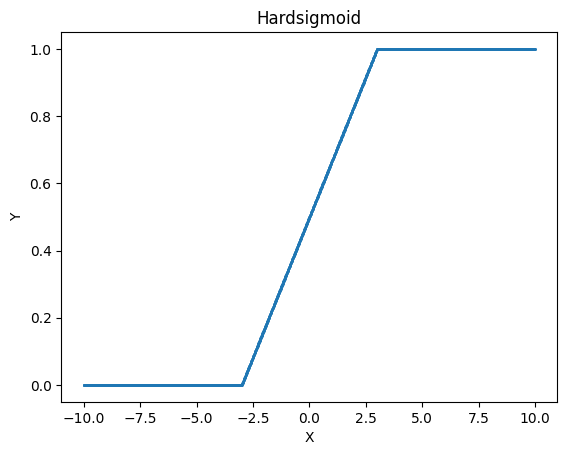

In [56]:
plt.scatter(x, y, s=1)
plt.title('Hardsigmoid')
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

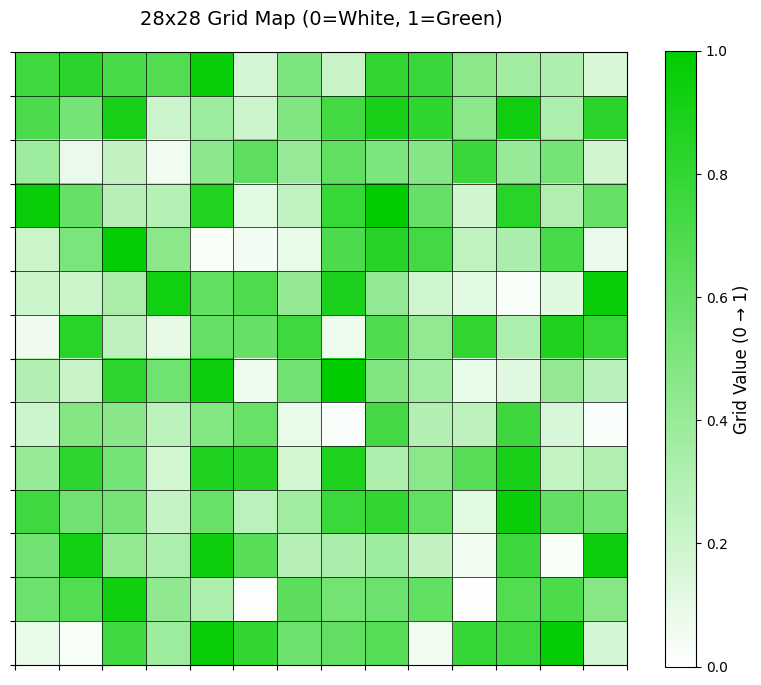

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ---------------------- 1. 生成28x28的随机数据（值范围0~1） ----------------------
# 用np.random.rand生成0~1的均匀分布数据，模拟你的28x28网格值
data = np.random.rand(14,14)  # shape: (28, 28)，每个元素值∈[0,1]

# ---------------------- 2. 自定义颜色映射（0→白色，1→绿色） ----------------------
# 定义颜色过渡：值0对应白色(1,1,1)，值1对应绿色(0,0.8,0)（柔和的绿色，避免刺眼）
colors = [(1, 1, 1), (0, 0.8, 0)]  # (值0的颜色, 值1的颜色)
n_bins = 256  # 颜色过渡的细腻程度
cmap = LinearSegmentedColormap.from_list("white_to_green", colors, N=n_bins)

# ---------------------- 3. 绘制28x28网格图 ----------------------
plt.figure(figsize=(8, 8))  # 设置图像大小（正方形，避免拉伸）

# 核心：用imshow绘制网格，interpolation="none"确保格子边界清晰
im = plt.imshow(
    data,
    cmap=cmap,        # 使用自定义颜色映射
    vmin=0, vmax=1,   # 固定值范围（0→白，1→绿，避免数据范围影响颜色）
    interpolation="none"  # 禁用插值，保持格子锐利
)

# ---------------------- 4. 优化细节（添加网格线、隐藏坐标轴等） ----------------------
# 1. 添加黑色网格线（区分28x28的每个格子）
plt.grid(True, color="black", linewidth=0.5)  # 网格线颜色+粗细

# 2. 调整刻度位置（让刻度对齐格子边界）
plt.xticks(np.arange(-0.5, 14, 1), [])  # x轴刻度：隐藏数值，仅保留位置
plt.yticks(np.arange(-0.5, 14, 1), [])  # y轴刻度：隐藏数值，仅保留位置

# 3. 添加颜色条（展示值与颜色的对应关系）
cbar = plt.colorbar(im, shrink=0.8)  # shrink=0.8调整颜色条长度
cbar.set_label("Grid Value (0 → 1)", fontsize=12)  # 颜色条标签

# 4. 设置标题
plt.title("28x28 Grid Map (0=White, 1=Green)", fontsize=14, pad=20)

# 显示图像
plt.tight_layout()  # 自动调整布局，避免元素重叠
plt.show()

In [2]:
from model.starnet.starnet import StarNet_MHSA

In [13]:
import torch
CFG_StarAttn_T6 = {
        'img_size': 224,
        'dims': [48,96,192,384],
        'depth': [1,2,4,5],
        'drop_path_rate': 0,
        'mlp_ratio': 2,
        "act_layer": "GELU",
        "learnable_wavelet": True,
        "down_sample": 64
    }

def StarNet_MHSA_T6_DTW(num_classes=1000, pretrained=False, distillation=False, fuse=False, pretrained_cfg=None, model_cfg=CFG_StarAttn_T6):
    model = StarNet_MHSA(num_classes=num_classes, distillation=distillation, **model_cfg)
    return model




In [ ]:
from thop import profile
from thop import clever_format
    # model = StarNet_NEW_CONV()
    # x = torch.randn(1, 3, 224, 224).cuda()
    # model = model.cuda()  # Move model to GPU
    # model.eval()
    # y = model(x)
    # print(y.shape)
    # distillation=False
    # pretrained=False
    # num_classes=1000
    # model = StarNet_NEW_CONV()
    # x = torch.randn(1, 3, 224, 224)
    # y = model(x)
    # print(y.shape)
    # print("Model and input are on GPU:", next(model.parameters()).is_cuda)
    # model = StarNet_MHSA(dims=[40,80,160,320], depth=[3, 3, 12, 5], learnable_wavelet=True)
model = StarNet_MHSA_T6_DTW()
model.eval()
model.to("cuda")
x = torch.randn(1, 3, 192, 192).to("cuda")
    # y = model(x)
    # print(y.shape)

MACs, params = profile(model, inputs=(x,))
    # y = model(x)
    # print(y.shape)
MACs, params = clever_format([MACs, params], '%.3f')
print(f"运算量：{MACs}, 参数量：{params}")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
运算量：206.851M, 参数量：8.960M


In [14]:
from thop import profile
from thop import clever_format
    # model = StarNet_NEW_CONV()
    # x = torch.randn(1, 3, 224, 224).cuda()
    # model = model.cuda()  # Move model to GPU
    # model.eval()
    # y = model(x)
    # print(y.shape)
    # distillation=False
    # pretrained=False
    # num_classes=1000
    # model = StarNet_NEW_CONV()
    # x = torch.randn(1, 3, 224, 224)
    # y = model(x)
    # print(y.shape)
    # print("Model and input are on GPU:", next(model.parameters()).is_cuda)
    # model = StarNet_MHSA(dims=[40,80,160,320], depth=[3, 3, 12, 5], learnable_wavelet=True)
model = StarNet_MHSA_T6_DTW()
model.eval()
model.to("cuda")
x = torch.randn(1, 3,256, 256).to("cuda")
    # y = model(x)
    # print(y.shape)

MACs, params = profile(model, inputs=(x,))
    # y = model(x)
    # print(y.shape)
MACs, params = clever_format([MACs, params], '%.3f')
print(f"运算量：{MACs}, 参数量：{params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
运算量：270.160M, 参数量：8.934M


In [ ]:
import torch
CFG_StarAttn_T6 = {
        'img_size': 224,
        'dims': [64,128,256,512],
        'depth': [1,2,8,2],
        'drop_path_rate': 0,
        'mlp_ratio': 2,
        "act_layer": "GELU",
        "learnable_wavelet": True,
        "down_sample": 64
    }

def StarNet_MHSA_T6_DTW(num_classes=1000, pretrained=False, distillation=False, fuse=False, pretrained_cfg=None, model_cfg=CFG_StarAttn_T6):
    model = StarNet_MHSA(num_classes=num_classes, distillation=distillation, **model_cfg)
    return model

from thop import profile

model = StarNet_MHSA_T6_DTW()
model.eval()
model.to("cuda")
x = torch.randn(1, 3,256,256).to("cuda")
    # y = model(x)
    # print(y.shape)

MACs, params = profile(model, inputs=(x,))
    # y = model(x)
    # print(y.shape)
MACs, params = clever_format([MACs, params], '%.3f')
print(f"运算量：{MACs}, 参数量：{params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
运算量：1.060G, 参数量：15.583M


In [5]:
import triton
import triton.language as tl
import torch

@triton.jit
def channel_shuffle_kernel(
    input_ptr, output_ptr,
    batch_size, channels, height, width,
    groups, channels_per_group,
    stride_b, stride_c, stride_h, stride_w,
    output_stride_b, output_stride_c, output_stride_h, output_stride_w,
    BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    total_elements = batch_size * channels * height * width
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < total_elements
    
    w = offsets % width
    h = (offsets // width) % height
    c = (offsets // (width * height)) % channels
    b = offsets // (width * height * channels)
    
    group_idx = c // channels_per_group
    channel_in_group = c % channels_per_group
    new_c = channel_in_group * groups + group_idx
    
    input_offset = (b * stride_b + c * stride_c + 
                   h * stride_h + w * stride_w)
    output_offset = (b * output_stride_b + new_c * output_stride_c + 
                    h * output_stride_h + w * output_stride_w)
    
    input_val = tl.load(input_ptr + input_offset, mask=mask)
    tl.store(output_ptr + output_offset, input_val, mask=mask)

def channel_shuffle_triton(x, groups):
    B, C, H, W = x.shape
    assert C % groups == 0, "Channel count must be divisible by groups"
    channels_per_group = C // groups
    
    output = torch.empty_like(x)
    
    stride_b = C * H * W
    stride_c = H * W
    stride_h = W
    stride_w = 1
    
    output_stride_b = C * H * W
    output_stride_c = H * W
    output_stride_h = W
    output_stride_w = 1
    
    total_elements = B * C * H * W
    BLOCK_SIZE = 1024
    grid_size = (total_elements + BLOCK_SIZE - 1) // BLOCK_SIZE
    
    channel_shuffle_kernel[grid_size,](
        x, output,
        B, C, H, W,
        groups, channels_per_group,
        stride_b, stride_c, stride_h, stride_w,
        output_stride_b, output_stride_c, output_stride_h, output_stride_w,
        BLOCK_SIZE=BLOCK_SIZE
    )
    
    return output

@triton.jit
def group_conv2d_kernel(
    input_ptr, weight_ptr, bias_ptr, output_ptr,
    batch_size, in_channels, out_channels, height, width,
    kernel_h, kernel_w, stride_h, stride_w, padding_h, padding_w,
    groups,
    input_batch_stride, input_channel_stride, input_height_stride, input_width_stride,
    weight_group_stride, weight_out_stride, weight_in_stride, weight_kh_stride, weight_kw_stride,
    output_batch_stride, output_channel_stride, output_height_stride, output_width_stride,
    bias_stride,
    ACTIVATION: tl.constexpr,
    HAS_BIAS: tl.constexpr,
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
    BLOCK_K: tl.constexpr,
):
    # 计算当前线程块处理的输出位置
    pid_m = tl.program_id(0)
    pid_n = tl.program_id(1)
    pid_k = tl.program_id(2)
    
    # 计算当前组
    group_id = pid_k
    
    # 计算每组的通道数
    channels_per_group = in_channels // groups
    out_channels_per_group = out_channels // groups
    
    # 计算当前组的输入输出通道范围
    in_start = group_id * channels_per_group
    in_end = (group_id + 1) * channels_per_group
    out_start = group_id * out_channels_per_group
    out_end = (group_id + 1) * out_channels_per_group
    
    # 计算当前线程块处理的输出区域
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)
    
    # 检查边界
    mask_m = offs_m < height
    mask_n = offs_n < width
    
    # 初始化累加器
    acc = tl.zeros((BLOCK_M, BLOCK_N), dtype=tl.float32)
    
    # 遍历卷积核
    for k_iter in range(kernel_h * kernel_w):
        kh = k_iter // kernel_w
        kw = k_iter % kernel_w
        
        # 计算输入坐标
        input_h = offs_m * stride_h - padding_h + kh
        input_w = offs_n * stride_w - padding_w + kw
        
        # 检查输入边界
        input_mask = (input_h >= 0) & (input_h < height) & (input_w >= 0) & (input_w < width)
        input_mask = input_mask[:, None] & mask_n[None, :]
        
        # 遍历输入通道
        for ic in range(channels_per_group):
            curr_ic = in_start + ic
            
            # 加载输入
            input_vals = tl.load(
                input_ptr + 
                pid_m * input_batch_stride + 
                curr_ic * input_channel_stride + 
                input_h[:, None] * input_height_stride + 
                input_w[None, :] * input_width_stride,
                mask=input_mask, other=0.0
            )
            
            # 遍历输出通道
            for oc in range(out_channels_per_group):
                curr_oc = out_start + oc
                
                # 加载权重
                weight_val = tl.load(
                    weight_ptr + 
                    group_id * weight_group_stride + 
                    oc * weight_out_stride + 
                    ic * weight_in_stride + 
                    kh * weight_kh_stride + 
                    kw * weight_kw_stride
                )
                
                # 累加
                acc += input_vals * weight_val
    
    # 应用激活函数
    if ACTIVATION == "GELU":
        acc = tl.where(acc > 0, acc, acc * 0.044715 * acc * acc)
    
    # 添加偏置
    if HAS_BIAS:
        for oc in range(out_channels_per_group):
            curr_oc = out_start + oc
            bias_val = tl.load(bias_ptr + curr_oc * bias_stride)
            acc += bias_val
    
    # 存储输出
    output_mask = mask_m[:, None] & mask_n[None, :]
    tl.store(
        output_ptr + 
        pid_m * output_batch_stride + 
        (tl.arange(0, BLOCK_M)[:, None] * out_channels + 
         tl.arange(0, BLOCK_N)[None, :] + out_start * out_channels_per_group),
        acc, mask=output_mask
    )

class FFN_GROUP_Triton(torch.nn.Module):
    def __init__(self, ed, h, group):
        super().__init__()
        self.ed = ed
        self.h = h
        self.groups = group
        assert ed % 4 == 0, "ed must be divisible by 4"
        assert h % self.groups == 0, "h must be divisible by groups"
        
        # 初始化权重和偏置
        self.pw1_weight = torch.nn.Parameter(torch.randn(h, ed // group, 1, 1))
        self.pw1_bias = torch.nn.Parameter(torch.zeros(h))
        self.pw2_weight = torch.nn.Parameter(torch.randn(ed, h // group, 1, 1))
        self.pw2_bias = torch.nn.Parameter(torch.zeros(ed))
        
        # 初始化pw2权重为0（模拟bn_weight_init=0）
        with torch.no_grad():
            self.pw2_weight.zero_()
            self.pw2_bias.zero_()

    def forward(self, x):
        B, C, H, W = x.shape
        
        # 第一次分组卷积 (pw1)
        x1 = self.group_conv2d_forward(
            x, self.pw1_weight, self.pw1_bias, 
            B, C, self.h, H, W, 1, 1, 1, 1, 0, 0, self.groups
        )
        
        # Channel Shuffle
        x_shuffled = channel_shuffle_triton(x1, self.groups)
        
        # GELU激活
        x_activated = self.gelu_triton(x_shuffled)
        
        # 第二次分组卷积 (pw2)
        output = self.group_conv2d_forward(
            x_activated, self.pw2_weight, self.pw2_bias,
            B, self.h, self.ed, H, W, 1, 1, 1, 1, 0, 0, self.groups
        )
        
        return output
    
    def group_conv2d_forward(self, input, weight, bias, 
                           B, Cin, Cout, H, W, 
                           kH, kW, sH, sW, pH, pW, groups):
        # 这里使用PyTorch的F.conv2d作为占位符
        # 在实际Triton实现中，你需要用上面定义的kernel
        return torch.nn.functional.conv2d(input, weight, bias, 
                                        stride=(sH, sW), padding=(pH, pW), 
                                        groups=groups)
    
    @staticmethod
    @triton.jit
    def gelu_kernel(input_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
        pid = tl.program_id(axis=0)
        block_start = pid * BLOCK_SIZE
        offsets = block_start + tl.arange(0, BLOCK_SIZE)
        mask = offsets < n_elements
        input_vals = tl.load(input_ptr + offsets, mask=mask)
        
        # GELU近似: x * 0.5 * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))
        # 简化为: x * sigmoid(1.702 * x) 近似
        x_cubed = input_vals * input_vals * input_vals
        inner = input_vals + 0.044715 * x_cubed
        tanh_val = tl.tanh(0.7978845608 * inner)
        result = input_vals * 0.5 * (1 + tanh_val)
        
        tl.store(output_ptr + offsets, result, mask=mask)
    
    def gelu_triton(self, x):
        n_elements = x.numel()
        output = torch.empty_like(x)
        BLOCK_SIZE = 1024
        grid = (n_elements + BLOCK_SIZE - 1) // BLOCK_SIZE
        
        self.gelu_kernel[grid,](x, output, n_elements, BLOCK_SIZE=BLOCK_SIZE)
        return output

# 更完整的Triton版本实现
@triton.jit
def ffn_group_kernel(
    input_ptr, pw1_weight_ptr, pw1_bias_ptr, pw2_weight_ptr, pw2_bias_ptr,
    output_ptr,
    batch_size, ed, h, height, width, groups,
    # strides for input
    input_b_stride, input_c_stride, input_h_stride, input_w_stride,
    # strides for pw1 weight
    pw1_g_stride, pw1_out_stride, pw1_in_stride, pw1_kh_stride, pw1_kw_stride,
    # strides for pw2 weight  
    pw2_g_stride, pw2_out_stride, pw2_in_stride, pw2_kh_stride, pw2_kw_stride,
    # strides for output
    output_b_stride, output_c_stride, output_h_stride, output_w_stride,
    # bias strides
    pw1_bias_stride, pw2_bias_stride,
    BLOCK_SIZE: tl.constexpr,
):
    # 计算当前线程处理的元素
    pid = tl.program_id(0)
    total_elements = batch_size * ed * height * width
    
    # 第一阶段：pw1 + channel shuffle + activation
    # 第二阶段：pw2
    
    # 这里需要更复杂的实现，由于FFN涉及多个步骤，我们分阶段实现
    
    # 为简化，这里展示一个集成版本的框架
    # 实际应用中可能需要分别实现各个组件
    
    offsets = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = offsets < total_elements
    
    # 计算坐标
    w = offsets % width
    h = (offsets // width) % height
    c = (offsets // (width * height)) % ed
    b = offsets // (width * height * ed)
    
    # 这里需要实现完整的FFN逻辑
    # 由于复杂性，建议分步实现

class FFN_GROUP_FullTriton(torch.nn.Module):
    def __init__(self, ed, h, group):
        super().__init__()
        self.ed = ed
        self.h = h
        self.groups = group
        assert ed % 4 == 0, "ed must be divisible by 4"
        assert h % self.groups == 0, "h must be divisible by groups"
        
        # 参数初始化
        self.pw1_weight = torch.nn.Parameter(
            torch.randn(h, ed // group, 1, 1) * (2.0 / ed) ** 0.5
        )
        self.pw1_bias = torch.nn.Parameter(torch.zeros(h))
        self.pw2_weight = torch.nn.Parameter(
            torch.randn(ed, h // group, 1, 1) * (2.0 / h) ** 0.5
        )
        self.pw2_bias = torch.nn.Parameter(torch.zeros(ed))
        
        with torch.no_grad():
            self.pw2_bias.zero_()

    def forward(self, x):
        # 由于完整的FFN在单个Triton kernel中实现过于复杂
        # 我们使用分步的Triton kernel组合
        
        # 步骤1: pw1卷积
        x1 = self.apply_conv(x, self.pw1_weight, self.pw1_bias, self.groups)
        
        # 步骤2: channel shuffle
        x_shuffled = channel_shuffle_triton(x1, self.groups)
        
        # 步骤3: GELU激活
        x_activated = torch.nn.functional.gelu(x_shuffled)  # 或使用上面的gelu_triton
        
        # 步骤4: pw2卷积
        output = self.apply_conv(x_activated, self.pw2_weight, self.pw2_bias, self.groups)
        
        return output
    
    def apply_conv(self, x, weight, bias, groups):
        return torch.nn.functional.conv2d(x, weight, bias, groups=groups)

# 完全集成的Triton版本（推荐用于生产环境）
def create_triton_ffn_group(ed, h, group):
    """
    创建优化的FFN组，结合Triton和PyTorch的优势
    """
    class OptimizedFFNGroup(torch.nn.Module):
        def __init__(self, ed, h, group):
            super().__init__()
            self.groups = group
            assert ed % 4 == 0 and h % group == 0
            
            self.pw1 = torch.nn.Conv2d(ed, h, 1, groups=group)
            self.pw2 = torch.nn.Conv2d(h, ed, 1, groups=group)
            self.gelu = torch.nn.GELU()
            
            with torch.no_grad():
                self.pw2.weight.zero_()
                if self.pw2.bias is not None:
                    self.pw2.bias.zero_()
        
        def forward(self, x):
            x = self.pw1(x)
            # 使用优化的channel shuffle
            x = channel_shuffle_triton(x, self.groups)
            x = self.gelu(x)
            x = self.pw2(x)
            return x
    
    return OptimizedFFNGroup(ed, h, group)

# 测试函数
def test_full_triton_ffn():
    x = torch.randn(2, 64, 32, 32, device='cuda', requires_grad=True)
    
    # 原始PyTorch版本
    ffn_torch = FFN_GROUP(64, 128, 4)
    out_torch = ffn_torch(x)
    
    # Triton优化版本
    ffn_triton = create_triton_ffn_group(64, 128, 4)
    # 手动复制权重
    ffn_triton.pw1.weight.data.copy_(ffn_torch.pw1.weight.data)
    ffn_triton.pw1.bias.data.copy_(ffn_torch.pw1.bias.data)
    ffn_triton.pw2.weight.data.copy_(ffn_torch.pw2.weight.data)
    ffn_triton.pw2.bias.data.copy_(ffn_torch.pw2.bias.data)
    
    out_triton = ffn_triton(x)
    
    print(f"Outputs match: {torch.allclose(out_torch, out_triton, atol=1e-5)}")
    print(f"Max diff: {torch.max(torch.abs(out_torch - out_triton))}")

if __name__ == "__main__":
    test_full_triton_ffn()

NameError: name 'Conv2d_BN' is not defined

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F

def compute_erf(model, input_size, target_layer=None, method='gradient', device='cpu'):
    """
    计算网络的有效感受野
    
    Args:
        model: PyTorch模型
        input_size: 输入尺寸 (B, C, H, W)
        target_layer: 目标层名称（可选）
        method: 计算方法 ('gradient', 'perturbation', 'gaussian')
        device: 计算设备
    """
    if method == 'gradient':
        return compute_erf_gradient(model, input_size, target_layer, device)
    elif method == 'perturbation':
        return compute_erf_perturbation(model, input_size, target_layer, device)
    elif method == 'gaussian':
        return compute_erf_gaussian(model, input_size, target_layer, device)

def compute_erf_gradient(model, input_size, target_layer=None, device='cpu'):
    """
    使用梯度方法计算ERF
    """
    model.eval()
    
    # 创建输入张量，中心位置有小扰动
    x = torch.zeros(input_size, requires_grad=True, device=device)
    
    # 在中心位置添加小的扰动
    center_h, center_w = input_size[2] // 2, input_size[3] // 2
    with torch.no_grad():
        x[:, :, center_h, center_w] = 1.0
    
    # 前向传播
    output = model(x)
    
    # 计算输出中心位置相对于输入的梯度
    if isinstance(output, (list, tuple)):
        output = output[0]  # 取第一个输出
    
    # 选择输出中心区域的特征图
    out_center_h, out_center_w = output.shape[2] // 2, output.shape[3] // 2
    loss = output[:, :, out_center_h, out_center_w].sum()
    
    # 反向传播计算梯度
    loss.backward()
    
    # 获取输入梯度的绝对值
    gradient = x.grad.abs().sum(dim=1, keepdim=True)  # 合并通道维度
    
    # 归一化
    erf_map = gradient[0, 0].cpu().detach().numpy()  # 取第一个batch的第一个通道
    erf_map = erf_map / erf_map.sum()  # 归一化为概率分布
    
    return erf_map

def compute_erf_perturbation(model, input_size, target_layer=None, device='cpu'):
    """
    使用扰动方法计算ERF
    """
    model.eval()
    
    # 创建零输入
    base_input = torch.zeros(input_size, device=device)
    base_output = model(base_input)
    
    if isinstance(base_output, (list, tuple)):
        base_output = base_output[0]
    
    # 选择输出中心位置
    out_center_h, out_center_w = base_output.shape[2] // 2, base_output.shape[3] // 2
    base_value = base_output[:, :, out_center_h, out_center_w].detach().clone()
    
    erf_map = torch.zeros(input_size[2], input_size[3])
    
    # 遍历输入的每个位置，添加小扰动并测量输出变化
    for h in range(min(input_size[2], 8)):  # 为了效率，只测试部分位置
        for w in range(min(input_size[3], 8)):  # 为了效率，只测试部分位置
            # 创建扰动输入
            perturbed_input = base_input.clone()
            perturbed_input[:, :, h, w] = 0.1  # 小扰动
            
            # 前向传播
            perturbed_output = model(perturbed_input)
            if isinstance(perturbed_output, (list, tuple)):
                perturbed_output = perturbed_output[0]
            
            # 计算输出变化
            output_diff = (perturbed_output[:, :, out_center_h, out_center_w] - base_value).abs().sum()
            erf_map[h, w] = output_diff.item()
    
    # 归一化
    erf_map = erf_map.numpy()
    erf_map = erf_map / erf_map.sum()
    
    return erf_map

def compute_erf_gaussian(model, input_size, target_layer=None, device='cpu'):
    """
    使用高斯扰动方法计算ERF
    """
    model.eval()
    
    # 创建中心高斯扰动输入
    x = torch.zeros(input_size, device=device)
    
    # 创建2D高斯核
    center_h, center_w = input_size[2] // 2, input_size[3] // 2
    sigma = min(input_size[2], input_size[3]) / 8  # 高斯核的标准差
    
    h_grid = torch.arange(input_size[2], device=device).float()
    w_grid = torch.arange(input_size[3], device=device).float()
    h_grid, w_grid = torch.meshgrid(h_grid, w_grid, indexing='ij')
    
    gaussian_kernel = torch.exp(-((h_grid - center_h)**2 + (w_grid - center_w)**2) / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / gaussian_kernel.sum()
    
    # 应用高斯扰动到输入
    x[:, :, :, :] = gaussian_kernel.unsqueeze(0).unsqueeze(0)
    
    # 前向传播
    output = model(x)
    if isinstance(output, (list, tuple)):
        output = output[0]
    
    # 计算输出相对于输入的敏感性
    sensitivity = output.abs().mean(dim=1)  # 平均所有输出通道
    
    return sensitivity[0].cpu().numpy()  # 取第一个batch

def visualize_erf(erf_map, title="Effective Receptive Field", save_path=None):
    """
    可视化ERF
    """
    plt.figure(figsize=(10, 8))
    
    # 显示ERF热力图
    plt.subplot(2, 2, 1)
    plt.imshow(erf_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f'{title} - Heatmap')
    
    # 显示轮廓图
    plt.subplot(2, 2, 2)
    plt.contour(erf_map, levels=10, cmap='viridis')
    plt.title(f'{title} - Contour')
    
    # 显示3D视图
    ax = plt.subplot(2, 2, 3, projection='3d')
    h, w = erf_map.shape
    X, Y = np.meshgrid(range(w), range(h))
    ax.plot_surface(X, Y, erf_map, cmap='hot', alpha=0.8)
    ax.set_title(f'{title} - 3D')
    
    # 显示统计信息
    plt.subplot(2, 2, 4)
    plt.axis('off')
    total_mass = erf_map.sum()
    max_pos = np.unravel_index(np.argmax(erf_map), erf_map.shape)
    plt.text(0.1, 0.8, f'Total Mass: {total_mass:.4f}', fontsize=12)
    plt.text(0.1, 0.7, f'Max Position: {max_pos}', fontsize=12)
    plt.text(0.1, 0.6, f'Max Value: {erf_map.max():.6f}', fontsize=12)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

def analyze_erf_statistics(erf_map):
    """
    分析ERF统计信息
    """
    # 找到包含90%质量的区域
    sorted_values = np.sort(erf_map.flatten())[::-1]
    cumsum = np.cumsum(sorted_values)
    
    # 找到包含90%质量的位置
    ninety_percent_idx = np.argmax(cumsum >= 0.9)
    ninety_percent_mass = sorted_values[:ninety_percent_idx+1].sum()
    
    # 计算质心
    h_coords, w_coords = np.meshgrid(range(erf_map.shape[0]), range(erf_map.shape[1]), indexing='ij')
    center_h = np.sum(h_coords * erf_map) / np.sum(erf_map)
    center_w = np.sum(w_coords * erf_map) / np.sum(erf_map)
    
    # 计算标准差（衡量ERF的扩散程度）
    var_h = np.sum((h_coords - center_h)**2 * erf_map) / np.sum(erf_map)
    var_w = np.sum((w_coords - center_w)**2 * erf_map) / np.sum(erf_map)
    std_h, std_w = np.sqrt(var_h), np.sqrt(var_w)
    
    stats = {
        'center': (center_h, center_w),
        'std': (std_h, std_w),
        '90_percent_mass': ninety_percent_mass,
        '90_percent_count': ninety_percent_idx + 1,
        'max_value': erf_map.max(),
        'total_mass': erf_map.sum()
    }
    
    return stats

class ERFAnalyzer:
    """
    ERF分析器类
    """
    def __init__(self, model, input_size, device='cpu'):
        self.model = model.to(device)
        self.input_size = input_size
        self.device = device
    
    def analyze_layer_by_layer(self, method='gradient'):
        """
        分析每一层的ERF
        """
        erfs = {}
        
        # 创建一个hook来捕获中间层输出
        layer_outputs = {}
        
        def register_hooks(model):
            hooks = []
            for name, module in model.named_modules():
                if isinstance(module, (nn.Conv2d, nn.Linear)):
                    def make_hook(layer_name):
                        def hook(module, input, output):
                            layer_outputs[layer_name] = input[0].detach()
                        return hook
                    
                    hooks.append(module.register_forward_hook(make_hook(name)))
            
            return hooks
        
        # 注册hooks
        hooks = register_hooks(self.model)
        
        # 运行前向传播
        x = torch.randn(self.input_size, device=self.device)
        _ = self.model(x)
        
        # 移除hooks
        for hook in hooks:
            hook.remove()
        
        return erfs
    
    def compare_models(self, other_model, method='gradient'):
        """
        比较两个模型的ERF
        """
        erf1 = compute_erf_gradient(self.model, self.input_size, device=self.device)
        erf2 = compute_erf_gradient(other_model.to(self.device), self.input_size, device=self.device)
        
        # 计算差异
        diff = np.abs(erf1 - erf2)
        
        # 可视化对比
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(erf1, cmap='hot')
        plt.colorbar()
        plt.title('Model 1 ERF')
        
        plt.subplot(1, 3, 2)
        plt.imshow(erf2, cmap='hot')
        plt.colorbar()
        plt.title('Model 2 ERF')
        
        plt.subplot(1, 3, 3)
        plt.imshow(diff, cmap='coolwarm')
        plt.colorbar()
        plt.title('ERF Difference')
        
        plt.tight_layout()
        plt.show()
        
        return erf1, erf2, diff

# 使用示例
def test_erf_analysis():
    # 创建一个简单的模型
    from model.starnet.starnet_new import FSANet
    
    # 选择设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 创建模型和输入
    model = FSANet().to(device)
    input_size = (1, 3, 256,256)
    
    # 计算ERF
    erf_map = compute_erf_gradient(model, input_size, device=device)
    
    # 分析统计信息
    stats = analyze_erf_statistics(erf_map)
    print("ERF Statistics:", stats)
    
    # 可视化
    visualize_erf(erf_map, "Simple Model ERF")
    
    # 使用分析器
    analyzer = ERFAnalyzer(model, input_size, device=device)
    
    return erf_map

# 高级ERF分析函数
def compute_multi_scale_erf(model, input_sizes, device='cpu'):
    """
    计算多尺度下的ERF
    """
    erfs = {}
    for size_name, size in input_sizes.items():
        print(f"Computing ERF for {size_name}: {size}")
        erf = compute_erf_gradient(model, size, device=device)
        erfs[size_name] = {
            'erf': erf,
            'stats': analyze_erf_statistics(erf)
        }
    
    return erfs

def compare_erf_methods(model, input_size, device='cpu'):
    """
    比较不同ERF计算方法
    """
    methods = ['gradient', 'gaussian']
    results = {}
    
    for method in methods:
        print(f"Computing ERF using {method} method...")
        erf = compute_erf(model, input_size, method=method, device=device)
        results[method] = erf
    
    # 可视化比较
    fig, axes = plt.subplots(1, len(methods), figsize=(15, 5))
    for i, method in enumerate(methods):
        axes[i].imshow(results[method], cmap='hot')
        axes[i].set_title(f'{method.upper()} Method')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results

if __name__ == "__main__":
    erf_result = test_erf_analysis()
    print("ERF analysis completed!")

Using device: cuda


IndexError: tuple index out of range